## Importing Library

In [1]:
import logging

from IPython.display import Image, display
import dowhy
import dowhy.datasets
from dowhy import CausalModel

## Importing Data

In [2]:
data = dowhy.datasets.linear_dataset(beta = 10,
                                    num_common_causes = 5,   # Confounders
                                    num_instruments = 2,    # Causes for Treatment 
                                    num_treatments = 1,     # Treatment
                                    num_samples = 10000,    # Data Samples
                                    treatment_is_binary= True, # Treatment -> Binary or Continuous
                                    outcome_is_binary= False)   # Outcome -> Binary or Continuous

df = data["df"]
df.head()

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.968149,-0.250206,0.485565,0.149687,-1.464741,0.485196,True,11.717867
1,0.0,0.663824,-0.927581,2.318864,-0.347377,0.559802,1.191548,True,15.429300
2,1.0,0.953922,-0.306363,0.473780,-0.464357,-1.884367,0.037188,True,7.151671
3,1.0,0.507809,-1.091532,-0.012821,0.015050,1.201288,-0.355771,True,8.863058
4,1.0,0.354824,0.470855,1.191723,-1.546701,-1.476383,0.964565,True,6.847631


## Model

In [14]:
model = CausalModel( data= df,
                   treatment= data["treatment_name"],
                   outcome=data["outcome_name"],
                   graph=data["gml_graph"],
                   instruments=data["instrument_names"],
                   logging_level = logging.INFO)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


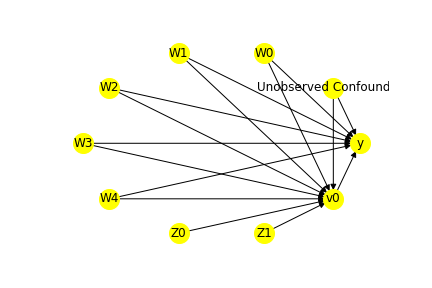

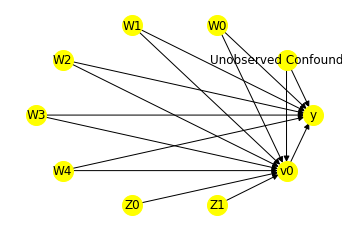

In [17]:
model.view_model()

display(Image(filename="causal_model.png"))

In [18]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W1', 'W0', 'W3', 'W2', 'Unobserved Confounders', 'W4']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W3,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,W4,U) = P(y|v0,W1,W0,W3,W2,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



## Methods

## 1. Regression

In [23]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
                                           method_name="backdoor.linear_regression",
                                           test_significance = True)
print(causal_estimate_reg)
print("The causal estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W3+W2+W4


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.490e+31
Date:                Mon, 27 Jul 2020   Prob (F-statistic):               0.00
Time:                        01:13:54   Log-Likelihood:             2.8839e+05
No. Observations:               10000   AIC:                        -5.768e+05
Df Residuals:                    9993   BIC:                        -5.767e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.295e-13   3.62e-15    -91.144      0.0

## 2. Stratification

In [29]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units = "att")
print(causal_estimate_strat)
print("The causal effect with stratification is " + str(causal_estimate_strat.value)) 

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W3+W2+W4


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W3,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,W4,U) = P(y|v0,W1,W0,W3,W2,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W0+W3+W2+W4
Target units: att

## Estimate
Mean value: 9.93471678234113

The causal effect with stratification is 9.93471678234113


C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 3.Matching

In [32]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units = "atc")
print(causal_estimate_match)
print("The causal effect with matching is " + str(causal_estimate_match.value)) 

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W3+W2+W4
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abhishek\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_matching_estimator.py:43: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
C:\Users\Abhishek\Anaconda3\lib\site-packages\dowhy\causal_estimators\propensity_score_matching_estimator.py:58: FutureWarning: `item` has been deprecated and will be removed in a future version
  treated_outcome = treated.iloc[indices[i]][self._outcome_name].item()


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W3,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,W4,U) = P(y|v0,W1,W0,W3,W2,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W0+W3+W2+W4
Target units: atc

## Estimate
Mean value: 10.250845402147998

The causal effect with matching is 10.250845402147998


## 4. Weighting

In [33]:
causal_estimate_weight = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_weighting",
                                              target_units = "ate",
                                              method_params={"weighting_scheme": "ips_weight"})
print(causal_estimate_weight)
print("The causal effect with weighting is " + str(causal_estimate_weight.value)) 

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v0+W1+W0+W3+W2+W4


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W3,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,W4,U) = P(y|v0,W1,W0,W3,W2,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W0+W3+W2+W4
Target units: ate

## Estimate
Mean value: 15.111094714130644

The causal effect with weighting is 15.111094714130644


C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abhishek\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 5. Instrumental Variables

In [35]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
                                              method_name="iv.instrumental_variable",
                                              method_params={"iv_instrument_name": "Z0"})
print(causal_estimate_iv)
print("The causal effect with weighting is " + str(causal_estimate_iv.value)) 

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common causes of ['v0'] and y



*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W3,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W3,W2,W4,U) = P(y|v0,W1,W0,W3,W2,W4)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {

## 6. Regression Discontinuity

In [36]:
causal_estimate_rd = model.estimate_effect(identified_estimand,
                                              method_name="iv.regression_discontinuity",
                                              method_params={"rd_variable_name": "Z1",
                                                            "rd_threshold_value" : 0.5,
                                                            "rd_bandwidth" : 0.1})
print(causal_estimate_rd)
print("The causal effect with weighting is " + str(causal_estimate_rd.value)) 

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome is affected in the same way by common causes of ['local_treatment'] and local_outcome



      local_rd_variable  local_treatment  local_outcome
1              0.579442             True      14.556649
3              0.403476             True      14.761922
8              0.430141             True       9.478627
10             0.502949             True      16.240132
16             0.426350             True      30.730214
...                 ...              ...            ...
9967           0.453985             True      14.570155
9968           0.540856             True       6.731268
9987           0.496034             True      16.560967
9991           0.533553             True       9.760060
9999           0.506404             True      15.281480

[2018 rows x 3 columns]
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W0,W3,W2,W4))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0